<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/Rhythmic_Input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.stats as st
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as ss

Setting parameters

In [2]:
#setting up mock population of presynaptic neurons

mean_fr = 10   # mean firing rate
std_fr = 2     # std firing rate

a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr  #End points for the truncated normal distribution
print('a = ',a)
print('b = ',b)

a =  -5.0
b =  45.0


In [3]:
d = partial(st.truncnorm.rvs, a=a, b=b, loc=mean_fr, scale=std_fr) 

# Creating a function to sample from a simulated population of cells with
# Truncated Normal distribution 
# mean firing rate = 10 
# Std of firing rate = 2
# bounds of -5.0 and 45

In [4]:
def modulateSimSpikes(n_cells,f,depth_of_mod):
  frs = d(size=n_cells) # Calling st.truncnorm.rvs to sample from simulated cells 
                      # Sample size = n_cells = 1000
                    

  t = np.arange(0,t_stop,0.001)
    # t is an array with values ranging from 0 to t_stop with increment 0.001
  z = np.zeros((n_cells,t.shape[0]))
    # Z is a n_cells by t.shape[0] ([1000][100]) matrix of 0's
  
  P = 0
   #Phase of sine wave

  #Loop through each cell
  for i in np.arange(0,n_cells):

    offset = frs[i] #Set 'offest' to the firing rate of cell i 

    mod_trace =  offset * (1 + depth_of_mod * np.sin((2 * np.pi * f * t ) + P))  #set the modulated firing rate values for cell i 
        # (2 * np.pi * f * t) :  an array of size t 
        # np.sin(  )          :  takes the sine of each value of the above array
        # depth_of_mod = 0 (no modulation)   -->  mod_trace = offset 
        # depth_of_mod = 1 (full modulation) -->  mod_trace = offset + (offset * (np.sin((2 * np.pi * f * t ) + P))) 


          #The above is algebrically equivalent to the following 

              # offset + (offset * depth_of_mod * np.sin((2 * np.pi * f * t ) + P))

          #And to:

              # A = offset * (np.sin((2 * np.pi * f * t ) + P) + 1)     #Setting the modulated term
              # B = offset                                              #Setting the constant term 
              # mod_trace = depth_of_mod*A + (1-depth_of_mod)*B         #Adding their components 

    z[i,:] = mod_trace
        # z[i,:] is the instantanous firing rate of cell i
        # Set the ith row of z to an array of firing rates for each time step 




  return z

Generate spikes with firing rates at each time step set bt z

In [5]:
def samplePoissonRVS(z):
#---
#   The Poisson distribution is a discrete probability distribution that expresses the probability of a 
#   given number of events occurring in a fixed interval of time or space if these events occur with a 
#   known constant mean rate and independently of the time since the last event.  
#
#   An unmodulated cell has a constant mean firing rate, but as modulation causes the firing rate to
#   change over time (phase) we consider each small time interval (as determined by length of the timestep) 
#   where the firing rate is constant.
#
#   For a given cell i and a given timestep t we model how many times cell i fires during timestep t
#   using the poisson distribution with λ being set to the firing rate for cell i at time t (adjusted 
#   to be the firing rate per milisecond, i.e. per timstep).
#
#   For a given cell this results in many timesteps that do not have spikes - but apoximatly 10 spikes every 1000 timesteps

  simSpks = []

  #Loop through each cell

  for i in np.arange(0,n_cells):

    r = z[i,:]

    r[r<0] = 0 #Can't have negative firing rates.


    numbPoints = scipy.stats.poisson(r/1000).rvs() 
      # numbPoints is an array of poisson random varibles with length of array = # of time steps
      # Each random variable is a poisson disribution that models the number of spikes that occur for cell i during the interval of each timestep
      # At each timestep t, cell i has a new freqency value given by z[i,t]
        # The poisson random variable that models the number of spikes that occur in cell i at timestep t has the parameter λ = Z[i,t]/1000

    simSpks.append(np.where(numbPoints>0)[0]) 
      # If a spike occurs for cell i at timestep t, append timestep t to simSpks
      # i.e. if the poisson random variable for cell i at timestep t takes a value of 1 then 't' will be appended to simSpks

  return simSpks

Ploting

In [6]:
# plt.plot(z[0,:])
# plt.plot(z[1,:])
# plt.plot(z[2,:])
# plt.plot(z[3,:])
# plt.xlim(0,100)

In [7]:
import numpy as np

def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

#Depth of modulation


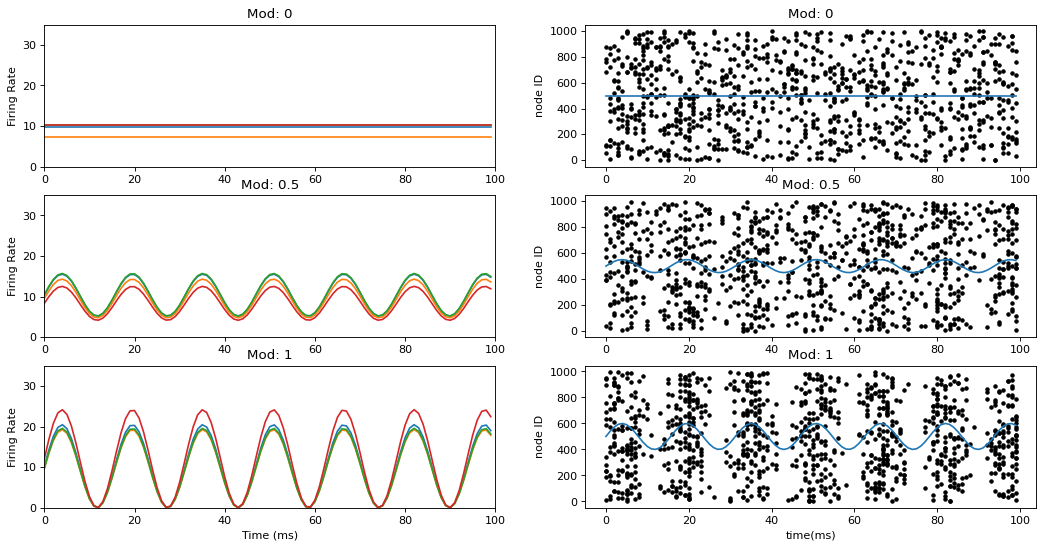

In [8]:
from matplotlib.pyplot import figure

#cols = ['Column {}'.format(col) for col in range(1, 2)]
#rows = ['Depth of mod = {}'.format(row) for row in ['0', '0.5', '1']]

figure(figsize=(16, 8), dpi=80)

# Depth of modulation  =  0

t_stop = 0.1 #seconds
n_cells = 1000 
depth_of_mod = 0 # depth of modulation #define 
f = 64 # frequency of oscillation (Gamma inhibition)
z = modulateSimSpikes(n_cells,f,depth_of_mod)

plt.subplot(3, 2, 1)
plt.plot(z[0,:])
plt.plot(z[1,:])
plt.plot(z[2,:])
plt.plot(z[3,:])
plt.xlim(0,100)
plt.ylim(0,35)
# plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.title("Mod: "+str(depth_of_mod))

plt.subplot(3, 2, 2)
raster = samplePoissonRVS(z)
for i in np.arange(0,z.shape[0]):
    plt.plot(raster[i],np.ones((raster[i].shape[0]))*i,'k.')
t = np.arange(0,t_stop,0.001)
plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
# plt.xlabel('time(ms)')
plt.ylabel('node ID')
plt.title("Mod: "+str(depth_of_mod))


# Depth of modulation  =  0.5

t_stop = 0.1 #seconds
n_cells = 1000 
depth_of_mod = 0.5 # depth of modulation #define 
f = 64 # frequency of oscillation (Gamma inhibition)
z = modulateSimSpikes(n_cells,f,depth_of_mod)

plt.subplot(3, 2, 3)
plt.plot(z[0,:])
plt.plot(z[1,:])
plt.plot(z[2,:])
plt.plot(z[3,:])
plt.xlim(0,100)
plt.ylim(0,35)
# plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.title("Mod: "+str(depth_of_mod))

plt.subplot(3, 2, 4)
raster = samplePoissonRVS(z)
for i in np.arange(0,z.shape[0]):
    plt.plot(raster[i],np.ones((raster[i].shape[0]))*i,'k.')
t = np.arange(0,t_stop,0.001)
plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
# plt.xlabel('time(ms)')
plt.ylabel('node ID')
plt.title("Mod: "+str(depth_of_mod))


# Depth of modulation  =  1

t_stop = 0.1 #seconds
n_cells = 1000 
depth_of_mod = 1 # depth of modulation #define 
f = 64 # frequency of oscillation (Gamma inhibition)
z = modulateSimSpikes(n_cells,f,depth_of_mod)

plt.subplot(3, 2, 5)
plt.plot(z[0,:])
plt.plot(z[1,:])
plt.plot(z[2,:])
plt.plot(z[3,:])
plt.xlim(0,100)
plt.ylim(0,35)
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.title("Mod: "+str(depth_of_mod))

plt.subplot(3, 2, 6)
raster = samplePoissonRVS(z)
for i in np.arange(0,z.shape[0]):
    plt.plot(raster[i],np.ones((raster[i].shape[0]))*i,'k.')
t = np.arange(0,t_stop,0.001)
plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
plt.xlabel('time(ms)')
plt.ylabel('node ID')
plt.title("Mod: "+str(depth_of_mod))


plt.show()

A single rhythmic input can be modeled by a sinusoid where the amplitude is the instantaneous firing rate. Sampling a poisson distribution according to the amplitude of the sinusoid at every time index will move events away from the  the timing of the sinusoid's trofts toward the timing of the sinusoid's peaks.

A gaussian distribution is often used to model inputs from a brain region. To model a population's rhythmic activity given this gaussian distribution, we can simply simple the gaussian for each cell and set the cell's firing rate to be a sinusoid that oscillates around the gaussian sampled firing rate, preserving the individual cell's mean firing rate.

Depth of modulation is a parameter that modifys the amplitude of the sinusoid to control the level of synchrony.

In [9]:
print(raster)

[array([], dtype=int64), array([83]), array([30, 49, 54]), array([50, 69]), array([5]), array([83]), array([], dtype=int64), array([49]), array([ 0, 34, 44]), array([], dtype=int64), array([30, 49]), array([79]), array([], dtype=int64), array([], dtype=int64), array([99]), array([82]), array([], dtype=int64), array([5, 7]), array([38, 45]), array([20, 65]), array([20]), array([ 1, 70]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([38]), array([], dtype=int64), array([30]), array([ 4, 63]), array([56]), array([3]), array([], dtype=int64), array([8]), array([], dtype=int64), array([], dtype=int64), array([20, 46]), array([97]), array([26, 33]), array([17, 33]), array([], dtype=int64), array([35, 46, 50]), array([82]), array([], dtype=int64), array([ 1, 17, 68]), array([50, 96]), array([49, 56, 96]), array([79, 98]), array([], dtype=int64), array([], dtype=int64), array([19]), array([], dtype=int64), array([98]), array([37, 95]), array([19]), array([], dt

In [10]:

# spikes_at_t = np.zeros((n_cells,t.shape[0]))
# fr_at_t = np.zeros(t.shape[0])


# for j in np.arange(0,t.shape[0]):
#   for i in np.arange(0,n_cells):
#     #spikes_at_t = np.count_nonzero()
#     spikes_at_t[i,j] += raster[i,j]
  
#   fr_at_t[j] = spikes_at_t[i,j] / 1000


# # avg = (totalSpks/1000)* (1/t_stop)
# # print(avg)


#We verify that the arverage firing rate is unchanged after modulation

In [11]:
def minmax(x):
    """min max normalizes the given array"""
    return (x - np.min(x))/(np.max(x)-np.min(x))

In [12]:
def make_pink_noise(num_traces=100,num_samples=4999):
    """
    Modulates a generated gausian white noise trace to create pink noise.
    
    Parameters
    ----------
    num_traces : int, optional
        number of noise traces to create (first dimension), by default 100
    num_samples : int, optional
        length of the trace (second dimension), by default 4999
    Returns
    -------
    np.array
        noise trace
    """    

    # Pink noise or ``1/f noise'' is an interesting case because there is no exact (rational, finite-order) filter which can produce it from white noise. 
    # This is because the ideal amplitude response of the filter must be proportional to the irrational function  1 / sqrt(f) , where f denotes frequency in Hz.
    # However, it is easy enough to generate pink noise to any desired degree of approximation

    #The following code generates pretty good pink noise:

    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]  #The coefficient A, B determines a filter that converts white noise to 1/f spectrum. 
    A = [1, -2.494956002,   2.017265875,  -0.522189400]         #You can use this function to check the frequency response of the filter, which should give you a 1/f amplitude response.

    invfn = np.zeros((num_traces,num_samples))
    for i in np.arange(0,num_traces):
        wn = np.random.normal(loc=1, scale=0.5, size=num_samples+2000)      # Generate Gausian white noise 
        invfn[i,:] = wn[2000:]
        invfn[i,:] = minmax(ss.lfilter(B, A, wn)[2000:])+0.5                # Filtering white noise to create a close approximation of '1/f' Noise
                                                                            # The filtered signal is pink noise with 0 mean. 
                                                                            # The minmax function normalizes the signal to have values between [0,1].
                                                                            # Adding 0.5 to it makes it positive and have mean 1, since firing rate cannot be negative
    return invfn




# One drawback of this method is that the variance of the generated firing rate is random due to the minmax normalization, 
# pretty much depending on the length of the generated signal.
# A better approach may be to choose a scaling factor that controls the variance of the generated pink noise and add 1 to it after scaling it to make it have mean 1. 
# The scaling should make the pink noise magnitude rarely be greater than 1. But if such value occurs, set it to the closest bound of [-1, 1].


Text(0, 0.5, 'node ID')

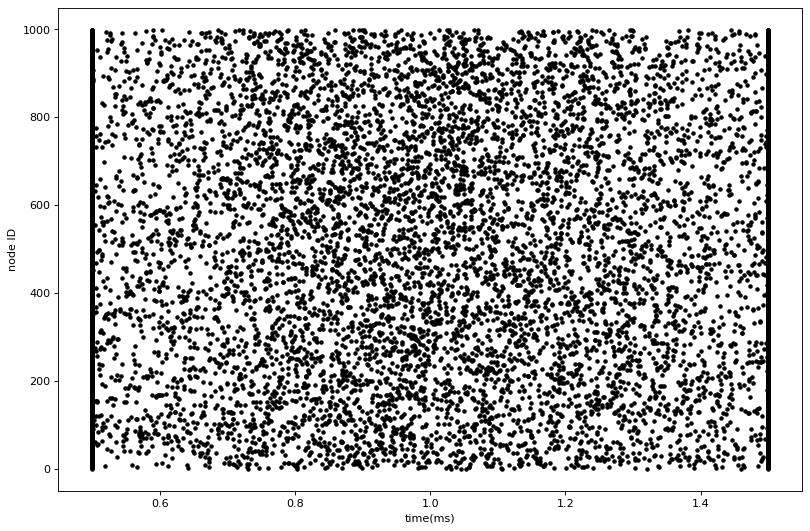

In [13]:
pinkNoise = make_pink_noise(1000, 10)


figure(figsize=(12, 8), dpi=80)
for i in np.arange(0,pinkNoise.shape[0]):
    plt.plot(pinkNoise[i],np.ones((pinkNoise[i].shape[0]))*i,'k.')
t = np.arange(0,t_stop,0.001)
#plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
plt.xlabel('time(ms)')
plt.ylabel('node ID')